# Gender recognition of voice DataSet from Kaggle 

In [290]:
import seaborn as sns
import sklearn as sk
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split #We need this to split the data
from sklearn.ensemble import RandomForestClassifier 

## Introduction (Describtion and Selection of the variables)

The first step is to get used to the data set, to get a keen overview I looked at the data in excel and try to explore what the Column Lable could mean, but most of them didn't make sense, thus I looked at kaggle and violá there is a ful describtion of all the variables:

meanfreq: mean frequency (in kHz) <br>
sd: standard deviation of frequency <br>
median: median frequency (in kHz) <br>
Q25: first quantile (in kHz) <br>
Q75: third quantile (in kHz) <br>
IQR: interquantile range (in kHz) <br>
skew: skewness (see note in specprop description) <br>
kurt: kurtosis (see note in specprop description) <br>
sp.ent: spectral entropy <br>
sfm: spectral flatness <br>
mode: mode frequency <br>
centroid: frequency centroid (see specprop) <br>
peakf: peak frequency (frequency with highest energy) <br>
meanfun: average of fundamental frequency measured across acoustic signal <br>
minfun: minimum fundamental frequency measured across acoustic signal<br>
maxfun: maximum fundamental frequency measured across acoustic signal<br>
meandom: average of dominant frequency measured across acoustic signal<br>
mindom: minimum of dominant frequency measured across acoustic signal<br>
maxdom: maximum of dominant frequency measured across acoustic signal<br>
dfrange: range of dominant frequency measured across acoustic signal<br>
modindx: modulation index. Calculated as the accumulated absolute difference between adjacent measurements of fundamental frequencies divided by the frequency range<br>
label: male or female<br>

"According to a CART model, it appears that looking at the mean fundamental frequency might be enough to accurately classify a voice. However, some male voices use a higher frequency, even though their resonance differs from female voices, and may be incorrectly classified as female. To the human ear, there is apparently more than simple frequency, that determines a voice's gender."

That sentence is totally true. However, from my experience it not easy to decide which of the indictors have a decisive meaning and which not. But for now if will delete the variables for the Quartiles and IQR, skew, kurt and the mode, because SD covers that in a way and the other variables seem to be more important.

After that correlations will be the decisive factore if variables should be in the predictive model or not. If the correlation is too high, one variable will be sorted out, to avoid redudance. 


In [291]:
df = pd.read_csv('voice.csv') #loading dataset
df.head() #checking if everything is properly loaded

,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,...,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx,label
0,0.059781,0.064241,0.032027,0.015071,0.090193,0.075122,12.863462,274.402906,0.893369,0.491918,...,0.059781,0.084279,0.015702,0.275862,0.007812,0.007812,0.007812,0.000000,0.000000,male
1,0.066009,0.067310,0.040229,0.019414,0.092666,0.073252,22.423285,634.613855,0.892193,0.513724,...,0.066009,0.107937,0.015826,0.250000,0.009014,0.007812,0.054688,0.046875,0.052632,male
2,0.077316,0.083829,0.036718,0.008701,0.131908,0.123207,30.757155,1024.927705,0.846389,0.478905,...,0.077316,0.098706,0.015656,0.271186,0.007990,0.007812,0.015625,0.007812,0.046512,male
3,0.151228,0.072111,0.158011,0.096582,0.207955,0.111374,1.232831,4.177296,0.963322,0.727232,...,0.151228,0.088965,0.017798,0.250000,0.201497,0.007812,0.562500,0.554688,0.247119,male
4,0.135120,0.079146,0.124656,0.078720,0.206045,0.127325,1.101174,4.333713,0.971955,0.783568,...,0.135120,0.106398,0.016931,0.266667,0.712812,0.007812,5.484375,5.476562,0.208274,male


In [292]:
df = df[['meanfreq','sd','sp.ent', 'sfm', 'meanfun', 'minfun', 'maxfun', 'meandom', 'mindom', 'maxdom', 'modindx', 'label']]

In [293]:
#sns.pairplot(df) 

Pairplot showed: High correlation between meanfreq and centranoid (keep meanfreq) and between
dfrange and maxdom (keep maxdom).

Fully aware that the assignment states that we should only proceed with 7 variables, I will ignore this default for the following reasons:
1. my contextual knowledge is too small to delete more variables with good conscience
2. many variables are no problem for Random Forest 
3. there are no missing values in the data set due to the technical measurement, which is why not too many cases (persons) are eliminated during data cleaning.

## Data Cleaning

The data set is very well prepared and due to the technical measurement there are few to no missing values. What needs to be mentioned,the removed variable "mode" contains the value 0 in some of the cases.
This means that the most frequent value of the recording is zero and thus pauses or silence are also included in the Mean Freq, but this has no significance when it comes to gender identification and can influence the result considerably. 
This clearly shows the disadvantage of a pre-processed data set.

In [294]:
df = df.dropna() #in case there are missing values

We want to predict the gender, but the gender (female or male) is called "label" which is confusing and also should be a int and not a string, thus this is the next step:

## Exploring Data Analysis

In [295]:
print(df['label'].value_counts())

male      1584
female    1584
Name: label, dtype: int64


the occurence of men and women in the data set is even. n = 3168

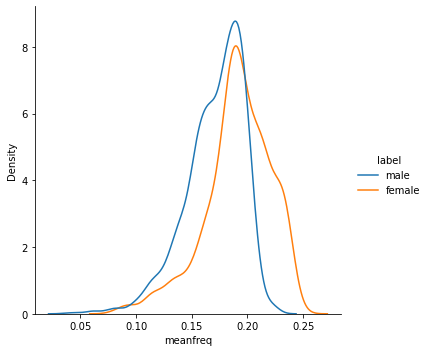

In [296]:
sns.displot(data = df, x = 'meanfreq', hue ='label', kind = 'kde')

One can see that the mean values of the frequency ranges clearly overlap and just the the lower men and the upper women voices can be distinquished by there mean frequence.That means maybe, the Q25 and Q75 would be better.

## Predictive Model (Random Forest)
"Label", which means gender: Either female or male. 
Use RandomForest, to predict female voices.

In [297]:
df['label'] = df['label'].replace('male', '0')
df['label'] = df['label'].replace('female', '1')
df = df[['meanfreq','sd','sp.ent', 'sfm', 'meanfun', 'minfun', 'maxfun', 'meandom', 'mindom', 'maxdom', 'modindx', 'label']]
df.head()

,meanfreq,sd,sp.ent,sfm,meanfun,minfun,maxfun,meandom,mindom,maxdom,modindx,label
0,0.059781,0.064241,0.893369,0.491918,0.084279,0.015702,0.275862,0.007812,0.007812,0.007812,0.000000,0
1,0.066009,0.067310,0.892193,0.513724,0.107937,0.015826,0.250000,0.009014,0.007812,0.054688,0.052632,0
2,0.077316,0.083829,0.846389,0.478905,0.098706,0.015656,0.271186,0.007990,0.007812,0.015625,0.046512,0
3,0.151228,0.072111,0.963322,0.727232,0.088965,0.017798,0.250000,0.201497,0.007812,0.562500,0.247119,0
4,0.135120,0.079146,0.971955,0.783568,0.106398,0.016931,0.266667,0.712812,0.007812,5.484375,0.208274,0


In [298]:
from sklearn.preprocessing import normalize #get the function needed to normalize our data.

X = df[['meanfreq','sd', 'sfm', 'meanfun', 'minfun', 'maxfun', 'meandom', 'mindom', 'maxdom']] #create the X matrix
X = normalize(X) #normalize the matrix to put everything on the same scale
y = df['label'] #create the y-variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=4) #split the data, store it into different variables

## Evaluation

In [299]:
from sklearn.ensemble import RandomForestClassifier #the object class we need

random = RandomForestClassifier(n_estimators=110) #create Random forest n_estimator default = 100
random = random.fit(X_train, y_train) #fit the train data
random.score(X_test, y_test) #calculate the fit on the test data

0.9558359621451105

the model has an accuracy of 95,6%, which means 4,4% are not predicted correctily.

In [300]:
from sklearn.metrics import confusion_matrix
y_test_pred = random.predict(X_test) #the predicted values
rf = confusion_matrix(y_test, y_test_pred) #creates a "confusion matrix"
rf

array([[458,  25],
       [ 17, 451]], dtype=int64)

In [301]:
#In order to read it easily , let's make a dataframe out of it, and add labels to it.
conf_matrix = pd.DataFrame(rf, index=['Male', 'Female'], columns = ['Male_p', 'Female_p']) 
conf_matrix

,Male_p,Female_p
Male,458,25
Female,17,451


In voice recognition model: False negative is exactly as bad as false positive, because the opposite is female or male, thus accuracy would be enough in that case, but only if we assume that there only two genders.

In [302]:
report = sk.metrics.classification_report(y_test, y_test_pred)
report

'              precision    recall  f1-score   support\n\n           0       0.96      0.95      0.96       483\n           1       0.95      0.96      0.96       468\n\n    accuracy                           0.96       951\n   macro avg       0.96      0.96      0.96       951\nweighted avg       0.96      0.96      0.96       951\n'

## Conclusion

We can predict a voice with 95% accuarcy through random forest.  For now, if this is good or bad is context dependent, but maybe knn brings better results.